In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.nn import Linear 

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_undirected, negative_sampling
from torch_geometric.loader import DataLoader
from torch_geometric.loader import NeighborLoader

import networkx as nx
from transformers import AutoModel, AutoTokenizer
import os
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import timeout_decorator
import time
import matplotlib.pyplot as plt


/media/alvaro-montero/9408123808121A36/Ubuntu_Programs/Anaconda/envs/gnn_proj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data


In [2]:
import random
def clean_text_strip(text):
   
    #Método usando strip() y split()
  
    lines = text.strip().split('\r\n')
    return ' '.join(line.strip() for line in lines)

def clean_text_regex(text):

    # Reemplaza cualquier combinación de \r y \n con un espacio
    text = re.sub(r'[\r\n]+', ' ', text)
    # Elimina espacios múltiples
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


#texts=load_books_and_split_to_paragraphs("/home/alvaro-montero/Escritorio/Repositorios/GNN_Project/Test text")

libros_ids = [17649,5475,7918,5624]#, 2873, 1004]#, 1013, 1028, 1059, 1064, 1065]#,
              #1080, 1086, 1119, 1399, 1321, 1301, 1260]#, 1257, 1228, 1227, 1184, 1245, 3010, 3047]
              #3056, 3059, 3152, 3160, 3207, 3289, 3323, 3332, 3435, 3436, 3437, 3438, 3439, 3440,
              #3441, 3442, 3443, 3444, 66041, 2500, 2554, 2591, 2600, 2638]  # IDs de los libros seleccionados 3623, 2873, 1998

capitulos = []  # Lista para almacenar capítulos de todos los libros
ids_sin_capitulos = []  # IDs de libros sin capítulos

lista_parrafos = []
titulos_libros = []
diccionario_subjects = []
metadata_grupos_parrafos = []

class TimeoutError(Exception):
    pass


@timeout_decorator.timeout(5, timeout_exception=TimeoutError)
def find_chapters_with_timeout(soup):
    """
    Busca capítulos con un límite de tiempo.
    Lanza TimeoutError si excede el tiempo límite.
    """
    return soup.find_all('div', class_='chapter')

id_parrafo = 0
# Recorrer cada ID de libro
for libro_id in libros_ids:
    url = f'https://www.gutenberg.org/cache/epub/{libro_id}/pg{libro_id}-images.html'

    # Realizar la solicitud HTTP
    response = requests.get(url)

    if response.status_code == 200:
        # Crear un objeto BeautifulSoup para analizar el HTML
        soup = BeautifulSoup(response.content, 'html.parser')

        try:
            start_time = time.perf_counter()
            # Encontrar todos los párrafos dentro del capítulo
            parrafos = [clean_text_regex(p.get_text()) for p in soup.find_all('p')]
            end_time = time.perf_counter()
            search_time = end_time - start_time

            # print(f"Búsqueda completada para libro {libro_id} en {search_time:.2f} segundos")
            

            if parrafos and len(parrafos) > 5:
                # URL base de la API de Project Gutenberg
                url = f"https://gutendex.com/books/{libro_id}"  # ID del libro Pride and Prejudice

                # Realizar la solicitud HTTP
                response = requests.get(url)

                # Verificar si la respuesta fue exitosa
                if response.status_code == 200:
                    metadata = response.json()

                    # Obtener el titulo del libro
                    title = metadata.get('title')
                            
                    # Acceder a la sección 'subjects'
                    subjects = metadata.get('subjects', [])
                    diccionario_subjects.append(subjects[0])
                
                    title_tag = title

                    if title_tag:
                        titulo = clean_text_regex(title_tag)
                        titulos_libros.append((libro_id, titulo))
                        print(f"id: {libro_id}, Titulo: {titulo}, tiempo : {search_time:.2f} segundos")
                    else:
                        titulos_libros.append((libro_id, f"Título no encontrado para libro {libro_id}"))
                    
                    # Lista para almacenar todos los capítulos de este libro
                    libro_capitulos = []

                    # Limite inferior para el grupo de parrafos
                    id_parrafo_inf = id_parrafo

                    # libro_capitulos.append(parrafos)
                    # Guardar cada parrafo en la lista general de todos los parrafos
                    for parrafo in parrafos:
                        longitud_parrafo = len(parrafo.split(" "))
                        if longitud_parrafo > 50: # Umbral para la cantidad de palabras por parrafo 
                            lista_parrafos.append(parrafo)
                            id_parrafo += 1
                    # Límite superior para el grupo de parrafos
                    id_parrafo_sup = id_parrafo

                    # Guardamos la información de la lista de parrafos para el libro actual
                    paragraph_data = {
                        "id_libro": libro_id,
                        "id_nodo_inferior": id_parrafo_inf,
                        "id_nodo_superior": id_parrafo_sup,
                        "title": title,
                        "subject": subjects[0]
                    }

                    metadata_grupos_parrafos.append(paragraph_data)

                    id_parrafo += 1
                                    
                    # print("len_lista_parrafos: ", len(lista_parrafos))
                            

                    # Si se encontraron capítulos, almacenarlos con el ID del libro
                    if libro_capitulos:
                        capitulos.append((libro_capitulos))
                else:
                    print("Error al obtener la metadata. Código de estado:", response.status_code)
            else: 
                # Si no se encontraron parrafos, agregar el ID a la lista de libros sin parrafos
                ids_sin_capitulos.append(libro_id)
        except TimeoutError:
            print(f"Timeout al buscar capítulos en libro {libro_id}")
            # Opcional: agregar el libro a una lista de libros que necesitan procesamiento especial
            continue
        except Exception as e:
            print(f"Error al procesar libro {libro_id}: {str(e)}")
            continue
    else:
        print(f"Error al acceder al libro con ID {libro_id}. Código de estado: {response.status_code}")

"""
texts=load_books_and_split_to_paragraphs("/home/alvaro-montero/Escritorio/Repositorios/GNN_Project/Test text")
for text in texts:
    text=eliminar_etiquetas(text)
    text=remover_apostrofes(text)
    text=remover_especiales(text)
    text=dobles_espacios(text)
"""

#texts=[ parrafo for ]
texts=lista_parrafos

mat_len=len(texts)
#adjw_matrix=torch.zeros(mat_len,mat_len)
print(mat_len)

id: 17649, Titulo: The Germ: Thoughts towards Nature in Poetry, Literature and Art, tiempo : 0.01 segundos
id: 5475, Titulo: Cleopatra — Volume 03, tiempo : 0.00 segundos
id: 7918, Titulo: American Historical and Literary Curiosities, Part 18.: Second Series, tiempo : 0.00 segundos
id: 5624, Titulo: The Inhumanity of Socialism, tiempo : 0.00 segundos
520


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Inicializar tokenizer y modelo
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")
bert_model = bert_model.to(device)  # Move model to GPU
def get_text_embeddings(texts):
    """Get embeddings for a single batch of texts"""
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    # Mover a GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  # Using [CLS] token
    return embeddings

Using device: cuda


In [4]:
#Obtener embeddings de bert
batch_size=96
dataloader = torch.utils.data.DataLoader(texts, batch_size=batch_size, shuffle=False)
    
embeddings_list = []
with torch.no_grad():
        for batch in tqdm(dataloader, desc="Procesando lotes", unit="lote"):
            batch_embeddings = get_text_embeddings(batch)
            embeddings_list.append(batch_embeddings.cpu())

node_embeddings = torch.cat(embeddings_list, dim=0)

print("Embeddings de nodos:", node_embeddings.shape)  # Debería ser (num_nodos, 768)
torch.cuda.synchronize() 

Procesando lotes: 100%|██████████| 6/6 [00:03<00:00,  1.51lote/s]

Embeddings de nodos: torch.Size([520, 768])


In [5]:
bert_model.cpu()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
node_embeddings.cpu()
torch.cuda.empty_cache()

In [74]:
#Scaled dot attention para obtener los pesos iniciales de la matriz de adyacencia
scores=torch.matmul(node_embeddings,node_embeddings.T)    

mask = torch.eye(scores.size(0), device=scores.device).bool()  # Matriz identidad
scores.masked_fill_(mask, float('-inf'))  # Establece -inf en la diagonal

mask = torch.triu(torch.ones_like(scores), diagonal=1).bool()
scores = scores * mask 
adjw_matrix=F.softmax(scores,dim=1)
threshold = 1/mat_len
adjw_matrix = torch.where(adjw_matrix < threshold, 
                            torch.zeros_like(adjw_matrix), 
                            adjw_matrix)
index_mat, weight_mat = torch_geometric.utils.dense_to_sparse(adjw_matrix)



## CLusters

In [8]:
from sklearn.decomposition import PCA
# Reducir dimensionalidad a 2D
pca = PCA(n_components=384)
embeddings_LD = pca.fit_transform(node_embeddings.numpy())

print("Embeddings reducidos a 1/2 Embedding dim (PCA):", embeddings_LD.shape)  # (num_nodos, 2)

Embeddings reducidos a 1/2 Embedding dim (PCA): (520, 384)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


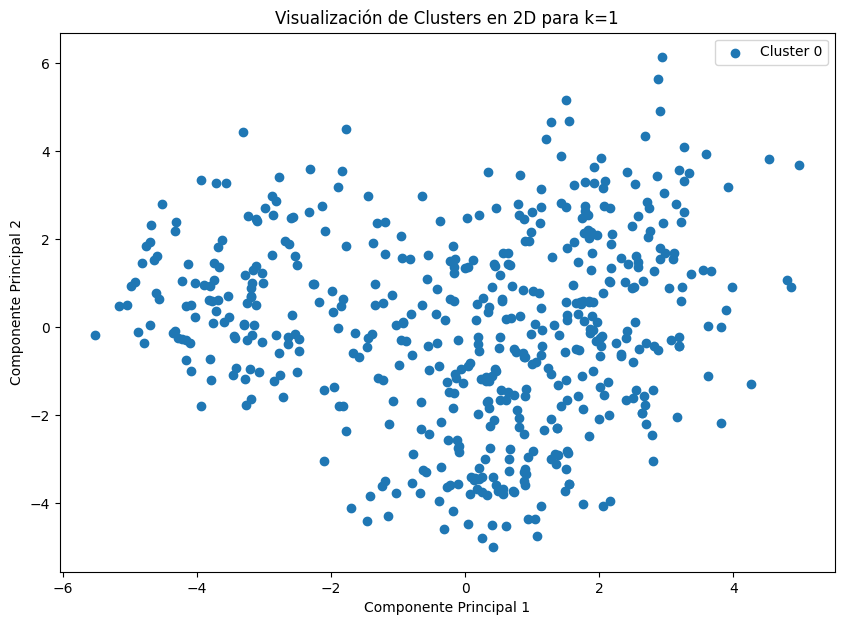

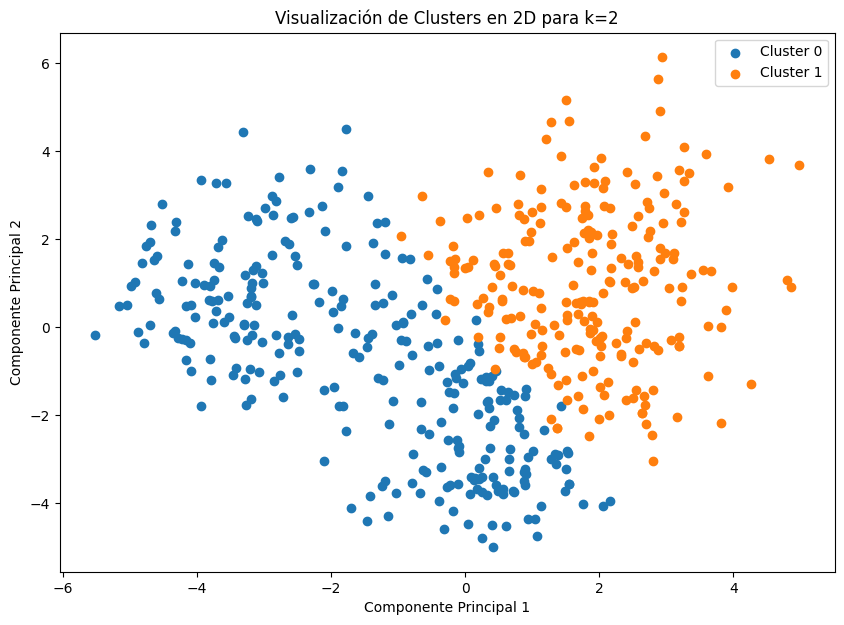

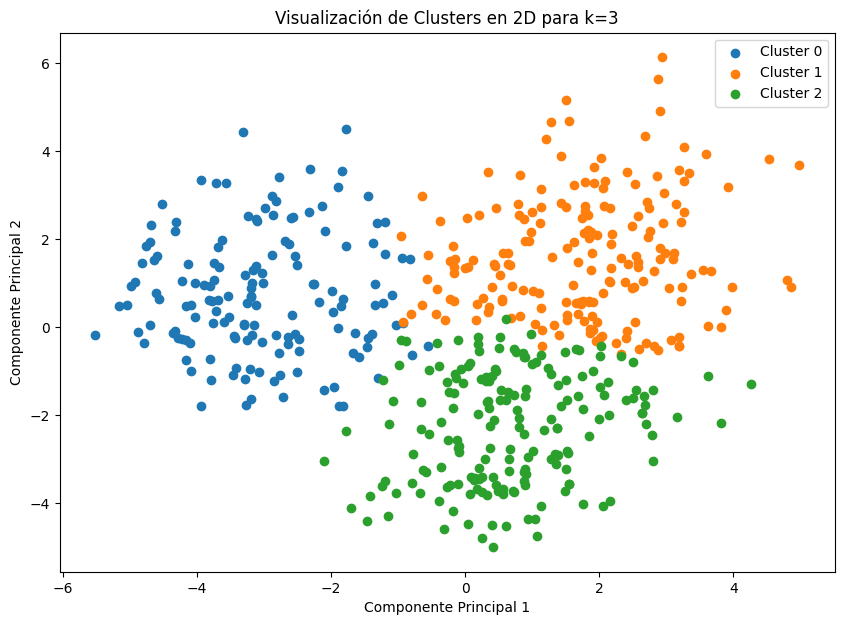

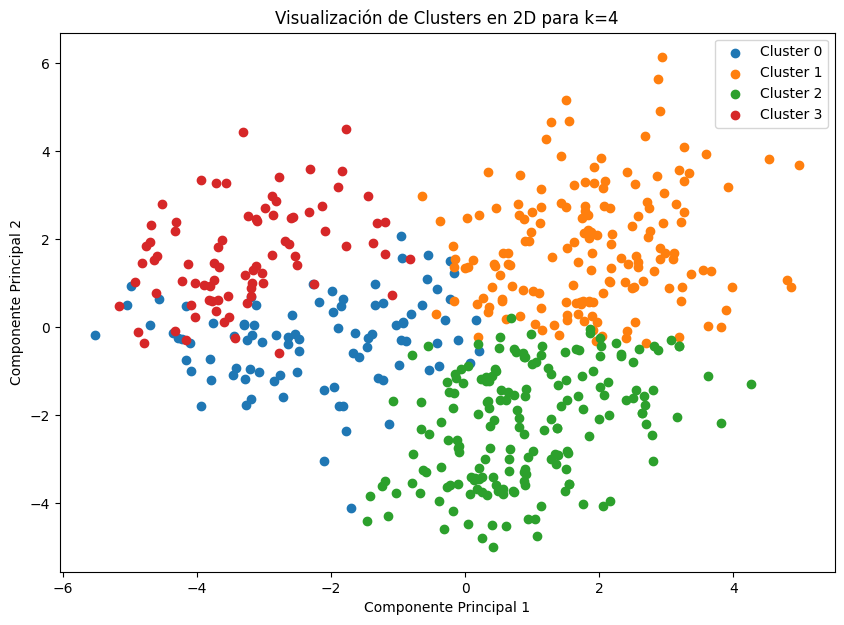

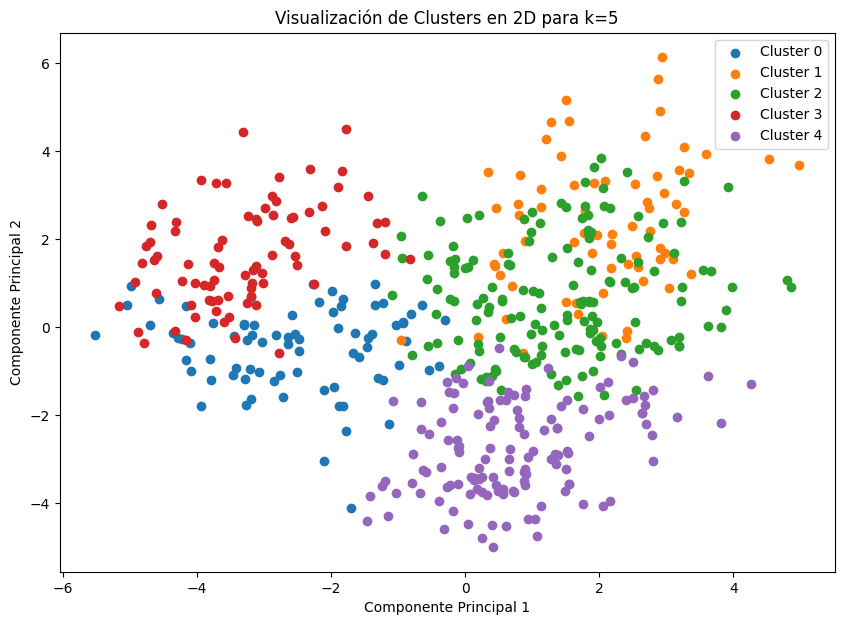

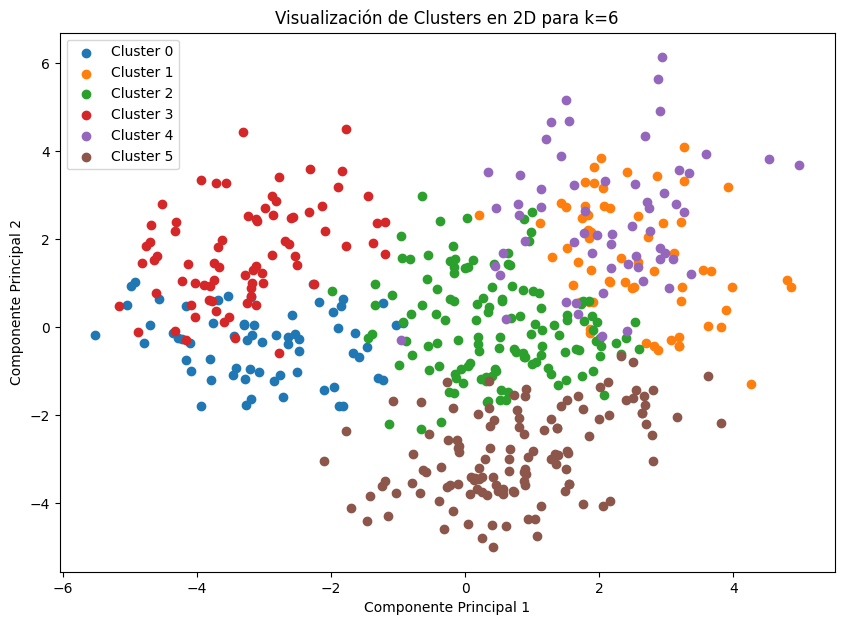

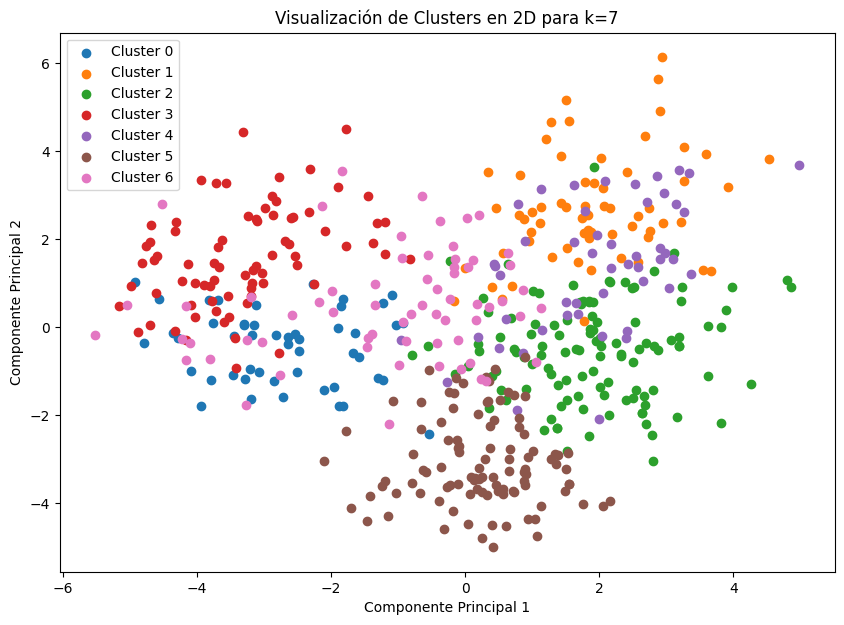

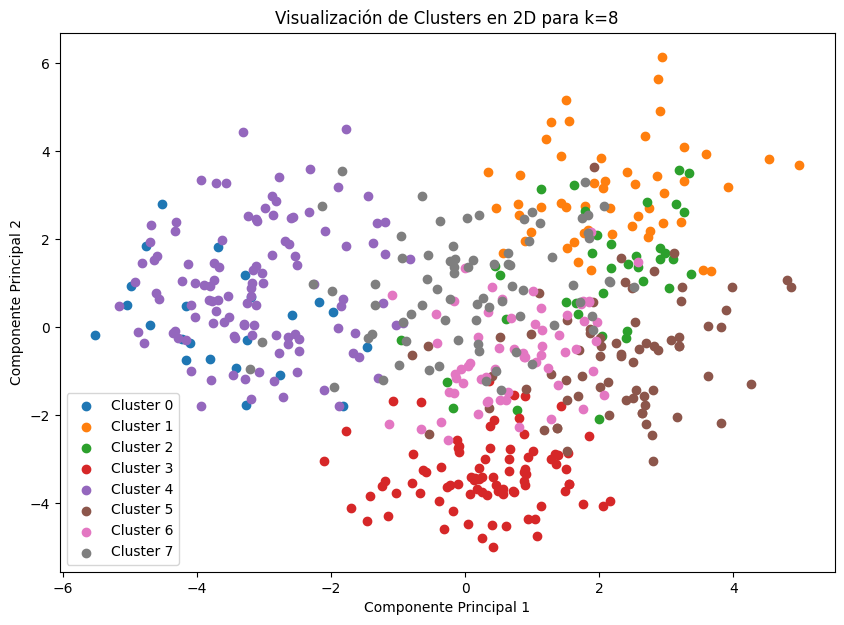

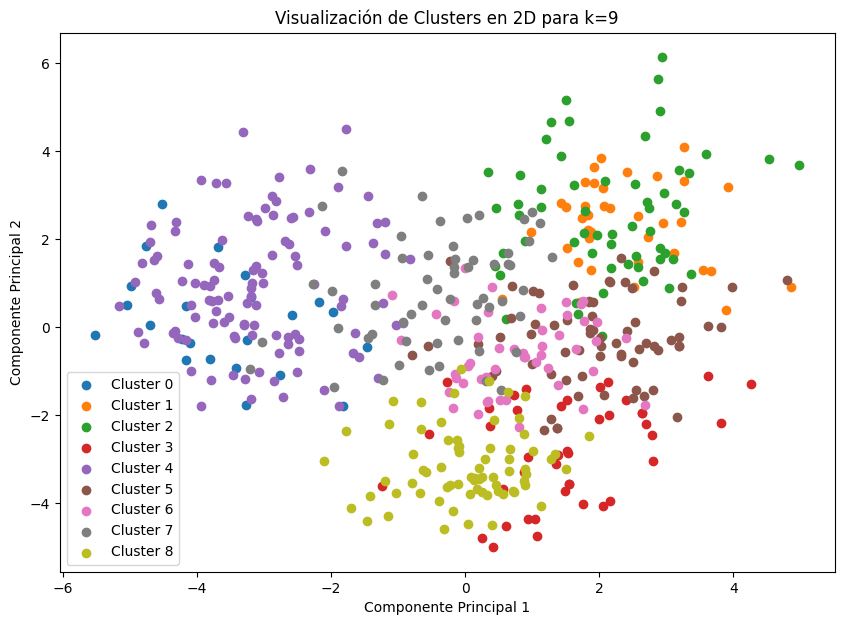

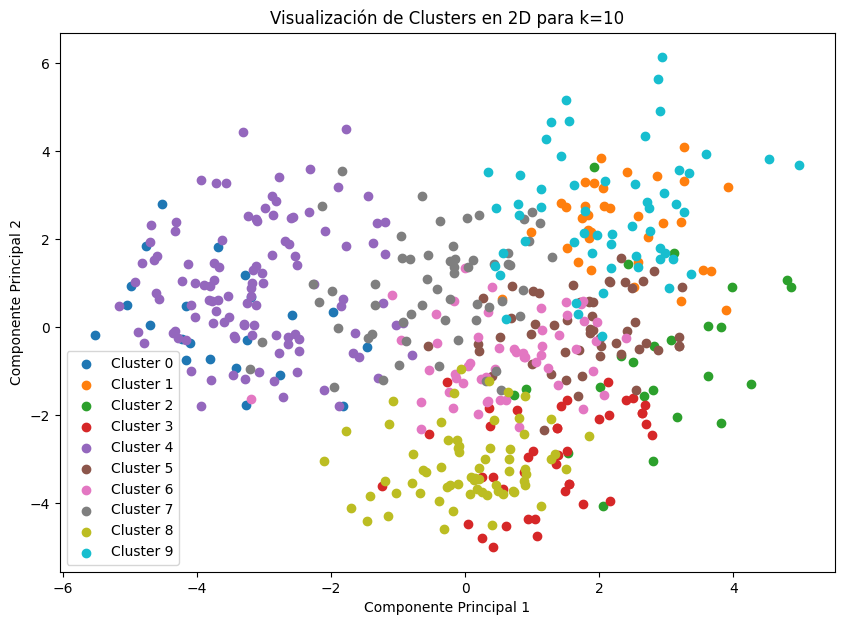

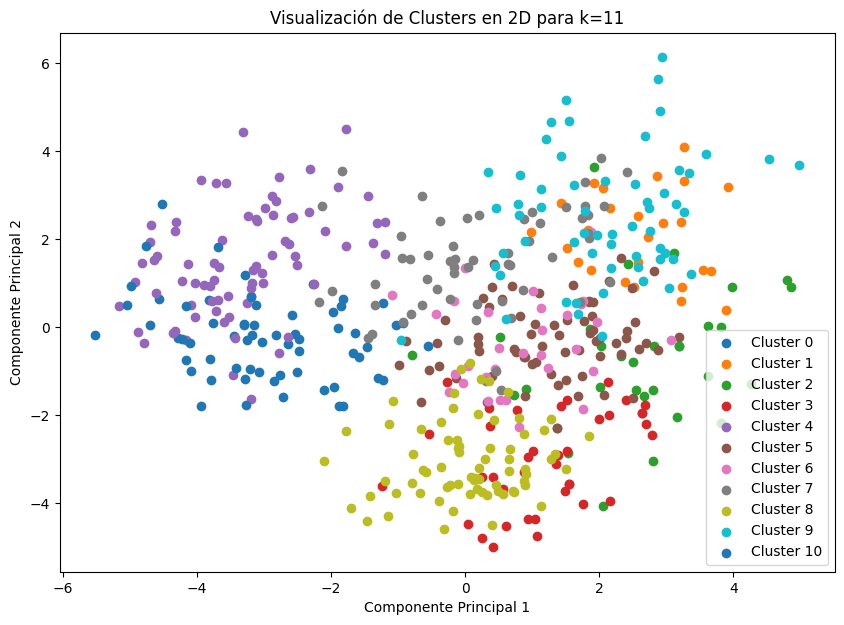

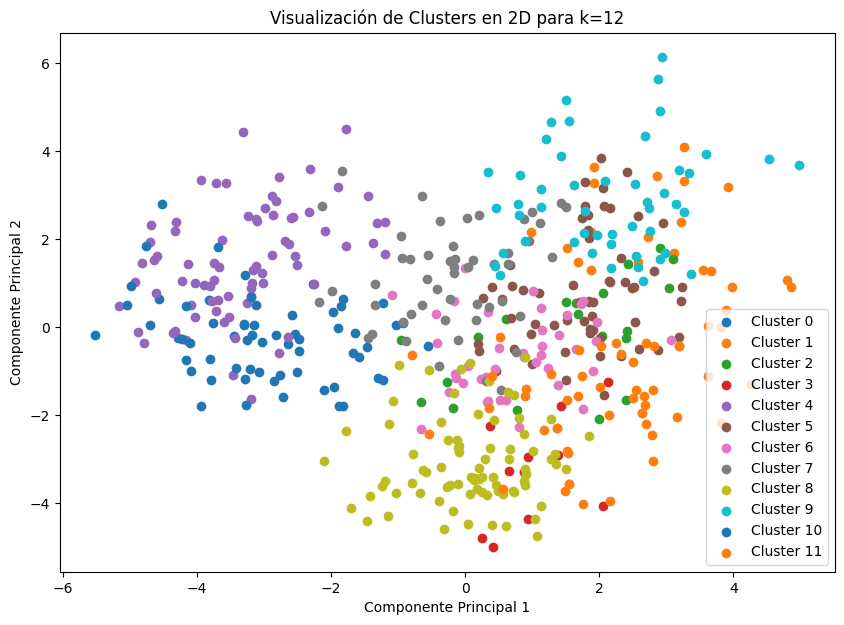

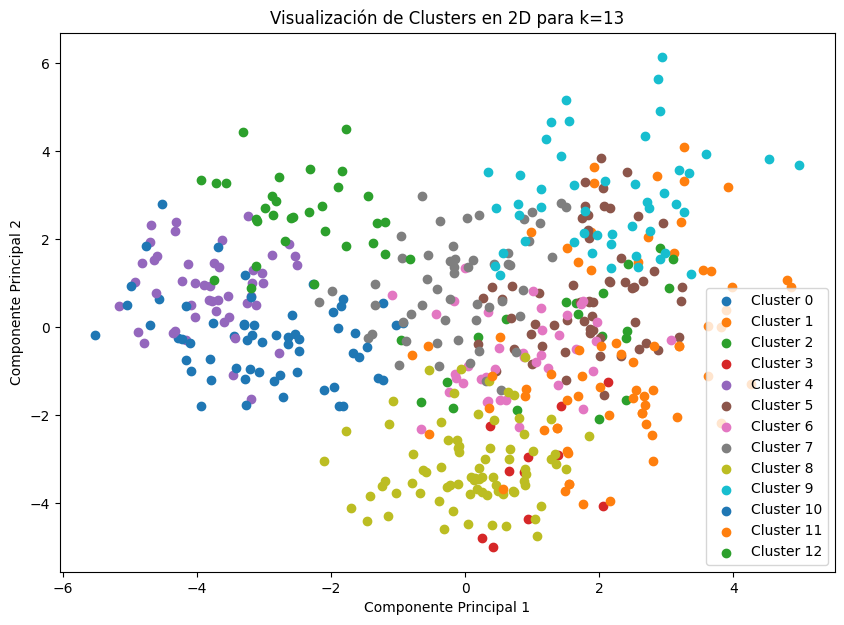

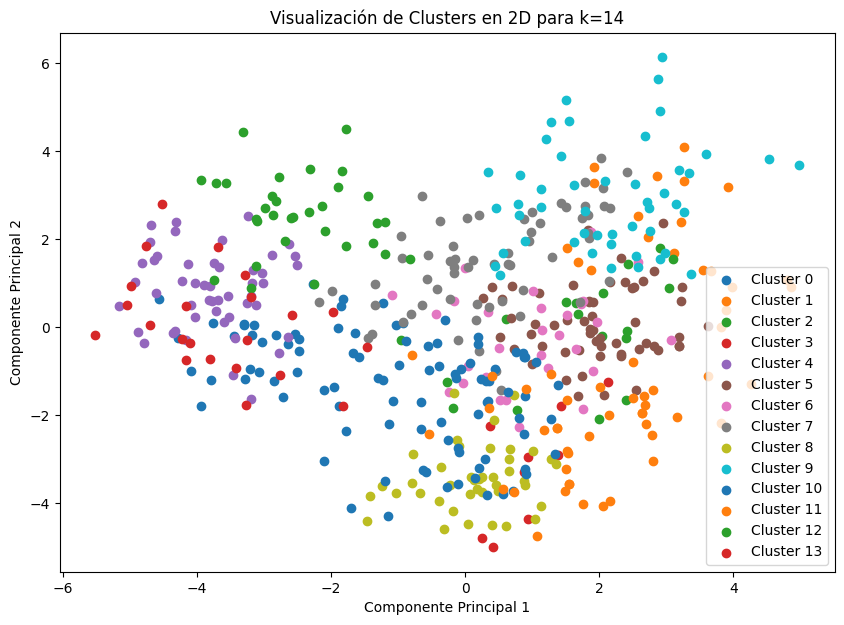

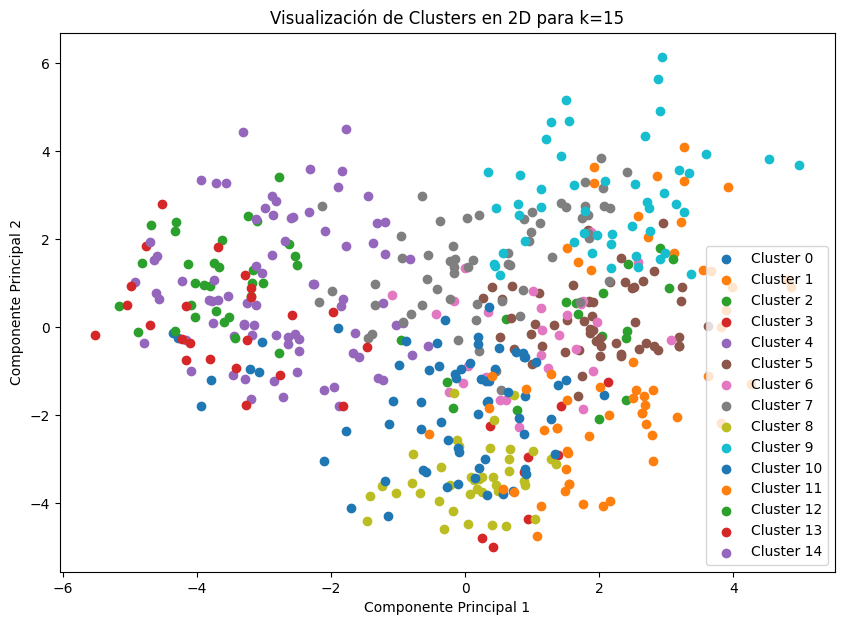

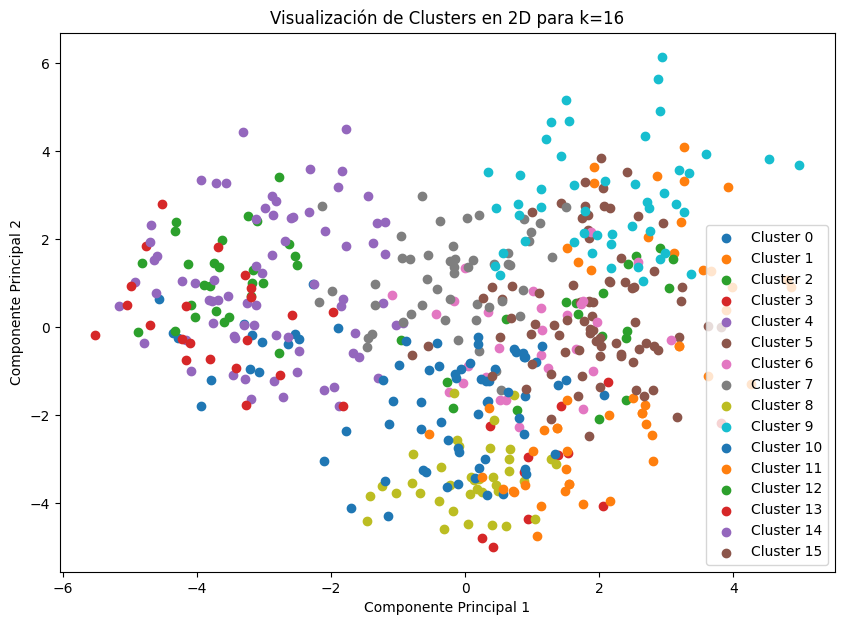

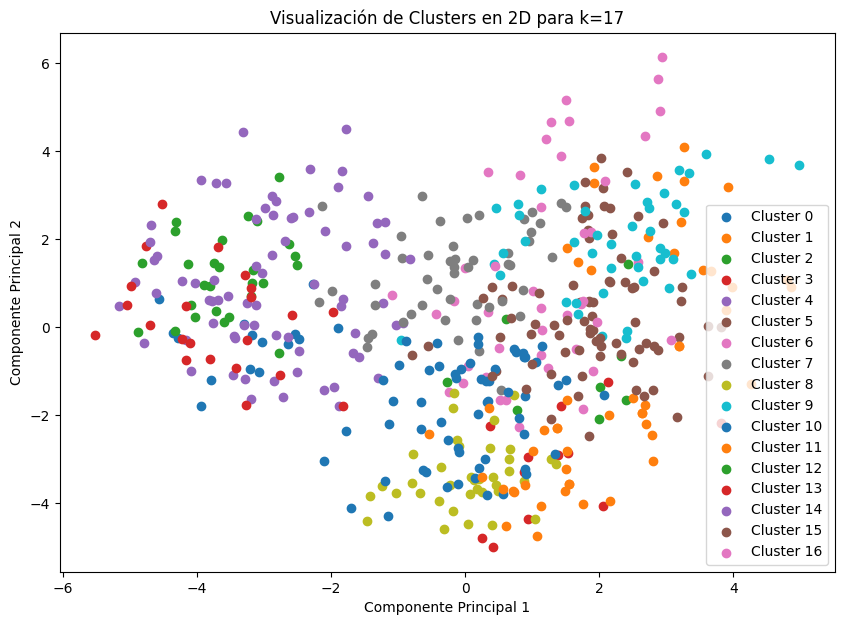

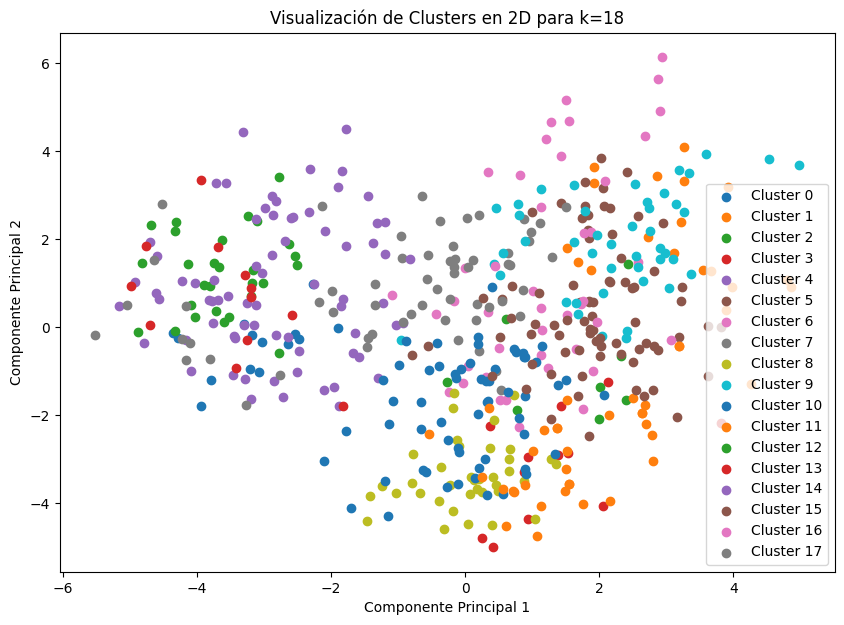

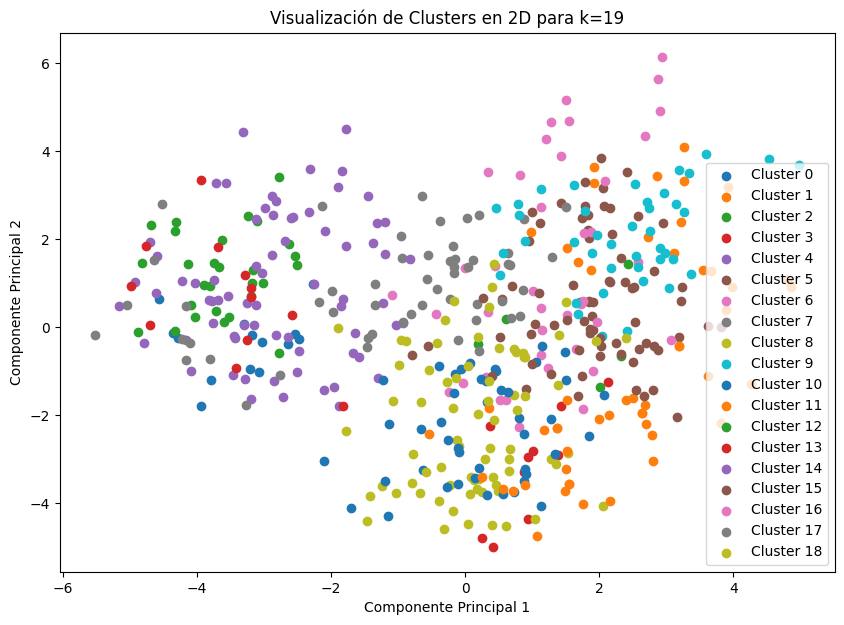

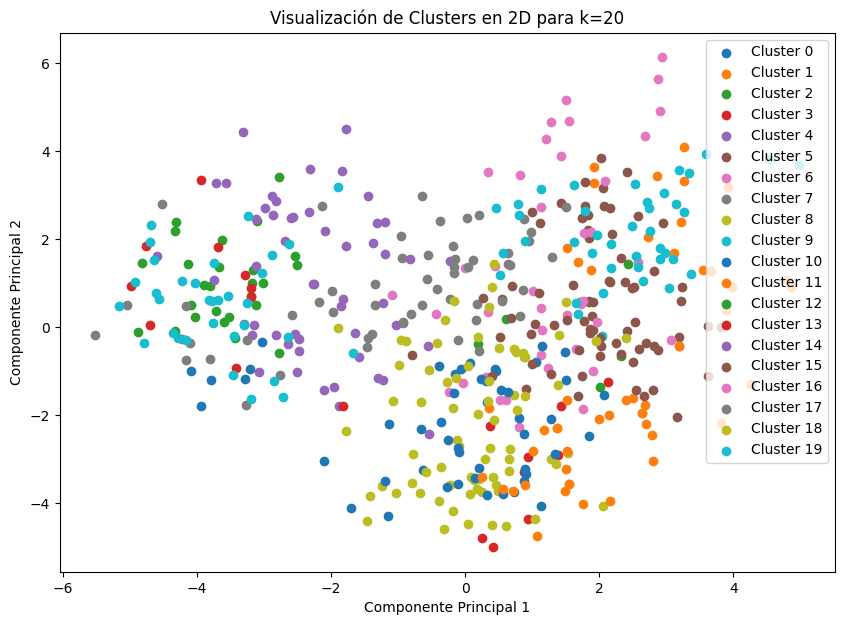

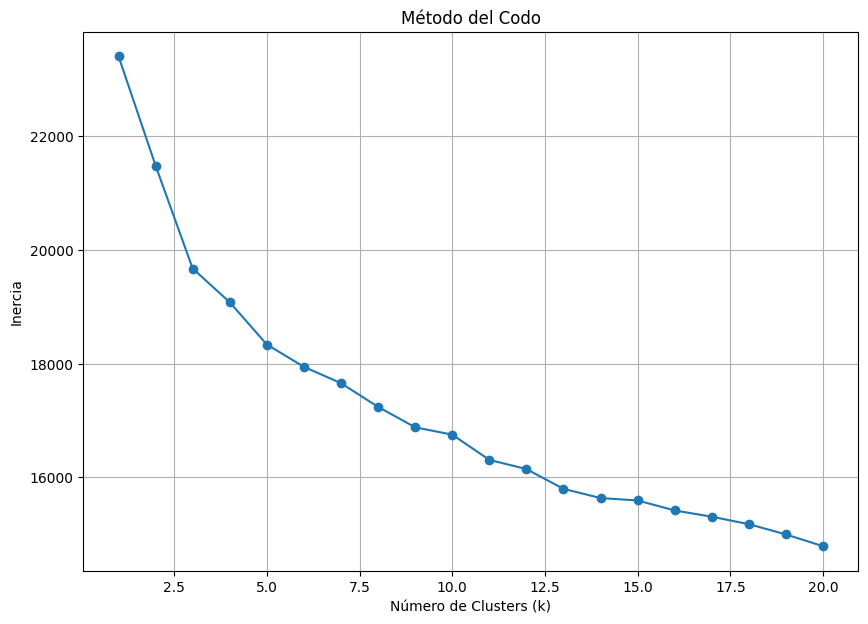

In [9]:

from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
inertias=[]
# Usar MiniBatchKMeans para clustering
for i in range(1, 21):
    # Aplica K-Means en todas las dimensiones originales o reducidas
    kmeans = KMeans(n_clusters=i, random_state=42)
    clusters = kmeans.fit_predict(embeddings_LD)
    inertias.append(kmeans.inertia_)

    # Reduce a 2D para visualización
    pca_2d = PCA(n_components=2)
    reduced_embeddings = pca_2d.fit_transform(embeddings_LD)

    # Visualiza los clusters en 2D
    plt.figure(figsize=(10, 7))
    for j in range(i):  # Itera sobre los clusters actuales
        plt.scatter(
            reduced_embeddings[clusters == j, 0], 
            reduced_embeddings[clusters == j, 1], 
            label=f'Cluster {j}'
        )

    plt.title(f'Visualización de Clusters en 2D para k={i}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.show()

# Gráfica del método del codo
plt.figure(figsize=(10, 7))
plt.plot(range(1, 21), inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

## graph generation


In [108]:
from copy import deepcopy

import torch_geometric.utils
class GATModel(torch.nn.Module): 
    def __init__(self, in_channels, hidden_channels, out_channels,adjw_mat, heads=8):
        super(GATModel, self).__init__()
        self.gat1 = torch_geometric.nn.GATConv(in_channels, hidden_channels, heads=heads)
        self.gat2 = torch_geometric.nn.GATConv(hidden_channels * heads, out_channels, heads=8)
        self.f_mat_index=torch.nn.Parameter(adjw_mat.float().to(device))
        self.f_mat_index.data = torch.clamp(self.f_mat_index.data, 0, 1)
    
    def to_cpu(self):
        """Mover todo el modelo a CPU."""
        self.gat1 = self.gat1.cpu()
        self.gat2 = self.gat2.cpu()
        self.f_mat_index = self.f_mat_index.cpu()
        if hasattr(self, 'edge_index'):
            self.edge_index = self.edge_index.cpu()

    def forward(self, data):
        self.edge_index, _ = torch_geometric.utils.dense_to_sparse(self.f_mat_index)
        self.edge_index=self.edge_index.to(device)
        _=[]
        
        
        x = data
        x = self.gat1(x, self.edge_index)
        x = torch.relu(x)
        x = self.gat2(x, self.edge_index)
        self.edge_index.cpu()
        return x

# Modelo de K-Means con GAT
class KMeansWithGAT:
    def __init__(self, n_clusters, in_features, hidden_dim, output_dim,adjw_mat, max_iter=100, device='cpu'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.device = device
        self.cluster_assignments = None

        # Crear el modelo GAT
        self.gat_model = GATModel(in_features, hidden_dim, output_dim,adjw_mat=adjw_mat).to(device)
        self.optimizer = torch.optim.Adam(list(self.gat_model.gat1.parameters())+list(self.gat_model.gat2.parameters())+[self.gat_model.f_mat_index], lr=0.005)

    def initialize_centroids(self, X):
        random_idx = np.random.choice((len(X)), self.n_clusters, replace=False)
        return X[random_idx].clone().to(self.device)

    
    def fit(self, loader):
        centroids = None
        history_loss=[]

        global_cluster_assignments = torch.full((len(loader.data.x,),), -1, dtype=torch.long)  # -1 indica sin asignación
        centroids = None

        for epoch in range(self.max_iter):
            for batch in loader:
                # Mover batch al dispositivo
                batch = batch.to(device)

                # Generar embeddings para los nodos en el batch actual
                embeddings = self.gat_model(batch.x)

                # Inicializar centroides en la primera iteración
                if centroids is None:
                    centroids = self.initialize_centroids(embeddings)

                # Normalizar nodos y centroides
                nodos_normalizados = F.normalize(embeddings, p=2, dim=1)
                centroides_normalizados = F.normalize(centroids, p=2, dim=1)

                # Calcular distancias y asignar clústeres
                distances = torch.mm(nodos_normalizados, centroides_normalizados.T)
                batch_cluster_assignments = torch.argmin(distances, dim=1)
                batch_cluster_assignments=batch_cluster_assignments.to(global_cluster_assignments.device)

                # Actualizar las asignaciones globales para los nodos en este batch
                global_cluster_assignments[batch.n_id] = batch_cluster_assignments

                # Actualizar centroides usando los nodos asignados del batch actual
                new_centroids = torch.stack([
                    embeddings[batch_cluster_assignments == k].mean(dim=0).detach()
                    if (batch_cluster_assignments == k).sum() > 0 else centroids[k]
                    for k in range(self.n_clusters)
                ])

                centroids = new_centroids  # Actualizar los centroides

                # Manejar nodos sin asignación al final de la época
                unassigned_nodes = (global_cluster_assignments == -1).nonzero(as_tuple=True)[0]
                if len(unassigned_nodes) > 0:
                    embeddings = self.gat_model(loader.x[unassigned_nodes], loader.edge_index)
                    distances = torch.mm(F.normalize(embeddings, p=2, dim=1), F.normalize(centroids, p=2, dim=1).T)
                    global_cluster_assignments[unassigned_nodes] = torch.argmin(distances, dim=1)

                print(f"Época {epoch}, asignaciones de clúster: {torch.bincount(global_cluster_assignments[global_cluster_assignments != -1])}")

                # Verificar convergencia
                """if torch.allclose(centroids, new_centroids, atol=1e-11):
                    print(f"Converged at epoch {epoch}")
                    self.centroids = centroids
                    self.cluster_assignments = cluster_assignments.cpu().numpy()
                    return"""

                
                
                try:
                    centroids = new_centroids
                    reg_loss = torch.sum((self.gat_model.f_mat_index - torch.round(self.gat_model.f_mat_index))**2).mean()
                    print(reg_loss)
                    loss = distances.mean()+reg_loss*1
                    loss.backward()
                    self.optimizer.step()
                    #self.gat_model.edge_index=torch_geometric.utils.dense_to_sparse(torch.round(self.gat_model.f_mat_index).long())
                except:
                    print("an optimization error has ocurred")
                history_loss.append(loss.clone().cpu())
                print(loss)
        self.centroids = centroids
        self.cluster_assignments = global_cluster_assignments.cpu().numpy()
        return history_loss
    
    def to_cpu(self):
        """Mover todo el modelo y sus parámetros a CPU."""
        self.device = 'cpu'
        self.gat_model.to_cpu()  # Llamar al método de GATModel
        if hasattr(self, 'centroids') and self.centroids is not None:
            self.centroids = self.centroids.cpu()
        if hasattr(self, 'cluster_assignments') and self.cluster_assignments is not None:
            self.cluster_assignments = torch.tensor(self.cluster_assignments).cpu().numpy()


    def predict(self, data):
        data = data.to(self.device)
        embeddings = self.gat_model(data.x)
        nodos_normalizados = F.normalize(embeddings, p=2, dim=1)  # Normalización fila por fila
        centroides_normalizados = F.normalize(self.centroids, p=2, dim=1) 
        distances = torch.mm(nodos_normalizados, centroides_normalizados.T)
        return torch.argmin(distances, dim=1).cpu().numpy()

In [102]:
node_embeddings = node_embeddings.contiguous()
adjw_matrix = adjw_matrix.contiguous()
adjw_matrix = torch.nan_to_num(adjw_matrix, nan=0.0, posinf=1.0, neginf=-1.0)

index_mat, weight_mat = torch_geometric.utils.dense_to_sparse(adjw_matrix)
if torch.isnan(index_mat).any() or torch.isinf(index_mat).any():
    print("f_mat_index contains NaN or Inf")

In [82]:
adjw_matrix.shape

torch.Size([520, 520])

In [83]:
node_embeddings.shape

torch.Size([520, 768])

In [84]:
num=node_embeddings.numel()
siz=node_embeddings.element_size()
num*siz

1597440

In [85]:
if torch.isnan(adjw_matrix).any() or torch.isinf(adjw_matrix).any():
    print("f_mat_index contains NaN or Inf")

In [15]:
#kmeans_gat=[]

In [103]:

n_clusters=6
in_features=node_embeddings.shape[1]
hidden_dim=128
output_dim=8
data_graph = Data(x=node_embeddings, edge_index=index_mat)
data=NeighborLoader(data_graph,num_neighbors=[30,30],batch_size=len(node_embeddings),shuffle=True)
kmeans_gat = KMeansWithGAT(n_clusters=n_clusters, in_features=in_features, hidden_dim=hidden_dim, output_dim=output_dim,adjw_mat=adjw_matrix,max_iter=100,device=device)
total_params = sum(p.numel() for p in kmeans_gat.gat_model.parameters())
print(total_params)

1125632


In [104]:
if torch.isnan(kmeans_gat.gat_model.f_mat_index).any() or torch.isinf(kmeans_gat.gat_model.f_mat_index).any():
    print("f_mat_index contains NaN or Inf")

In [109]:
# Entrenar el modelo

history=kmeans_gat.fit(data)
cluster_assignments = kmeans_gat.cluster_assignments
#embeddings = kmeans_gat.gat_model(data_graph).cpu().detach.numpy()
centroids = kmeans_gat.centroids.cpu().detach().numpy()

# Predecir y graficar resultados


Época 0, asignaciones de clúster: tensor([ 13,   3, 236, 268])
tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9766, device='cuda:0', grad_fn=<AddBackward0>)
Época 1, asignaciones de clúster: tensor([465,   0,  21,   0,  17,  17])
tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
an optimization error has ocurred
tensor(0.9783, device='cuda:0', grad_fn=<AddBackward0>)
Época 2, asignaciones de clúster: tensor([  0, 407,  36,  39,   1,  37])
tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
an optimization error has ocurred
tensor(0.9869, device='cuda:0', grad_fn=<AddBackward0>)
Época 3, asignaciones de clúster: tensor([  0,   3,  89,  59, 104, 265])
tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
an optimization error has ocurred
tensor(0.9889, device='cuda:0', grad_fn=<AddBackward0>)
Época 4, asignaciones de clúster: tensor([  0, 434,  28,  30,   1,  27])
tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
an optimization error has ocurred
tensor(0.9900, devic

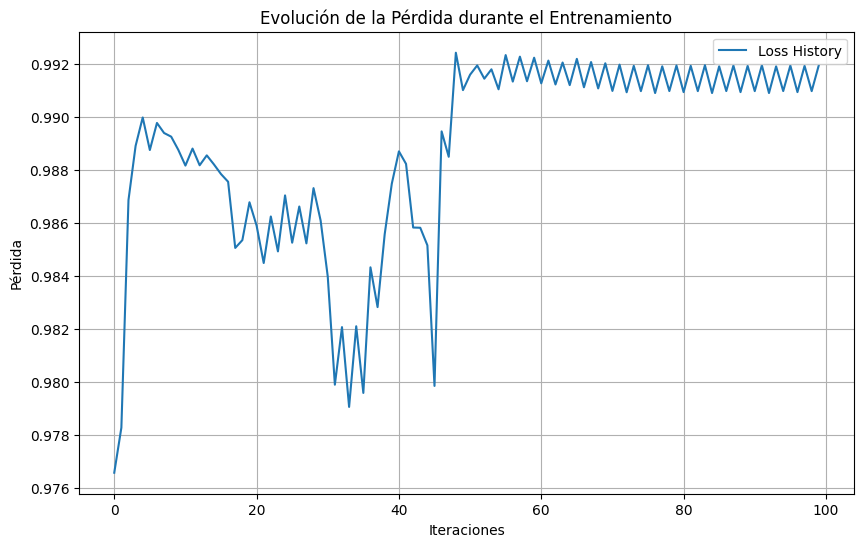

In [110]:
history_loss_values = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in history]

# Graficar la evolución de la pérdida
plt.figure(figsize=(10, 6))
plt.plot(history_loss_values, label='Loss History')
plt.title('Evolución de la Pérdida durante el Entrenamiento')
plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
cluster_assignments.shape

(520,)

In [98]:
for i in range(20):
    print(cluster_assignments[-i])

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5


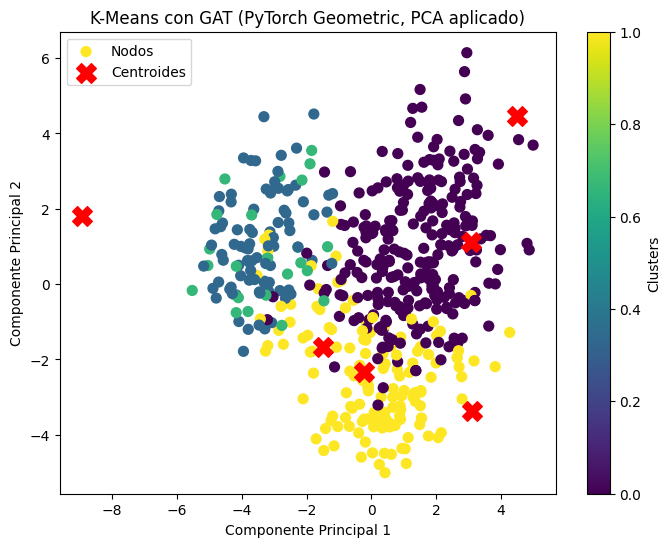

In [111]:

embeddings_prov=node_embeddings[:len(cluster_assignments)]
pca = PCA(n_components=2)
node_embeddings_2d = pca.fit_transform(embeddings_prov)

# Aplicar PCA a los centroides
centroids_2d = pca.fit_transform(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=cluster_assignments, cmap='viridis', s=50, label="Nodos")
plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], c='red', s=200, marker='X', label="Centroides")
plt.title("K-Means con GAT (PyTorch Geometric, PCA aplicado)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Clusters")
plt.legend()
plt.show()

In [22]:
centroids_2d

array([[ 3.4551880e+03, -1.4417681e+00],
       [ 5.8205571e+03,  7.1322803e+00],
       [-5.7274253e+03,  7.3467956e+00],
       [-1.1921016e+03, -5.8079119e+00],
       [-3.4737795e+03, -1.4599006e+00],
       [ 1.1175574e+03, -5.7706547e+00]], dtype=float32)

In [23]:
torch.cuda.empty_cache()

In [120]:
index_output=kmeans_gat.gat_model.f_mat_index.detach().cpu().numpy()

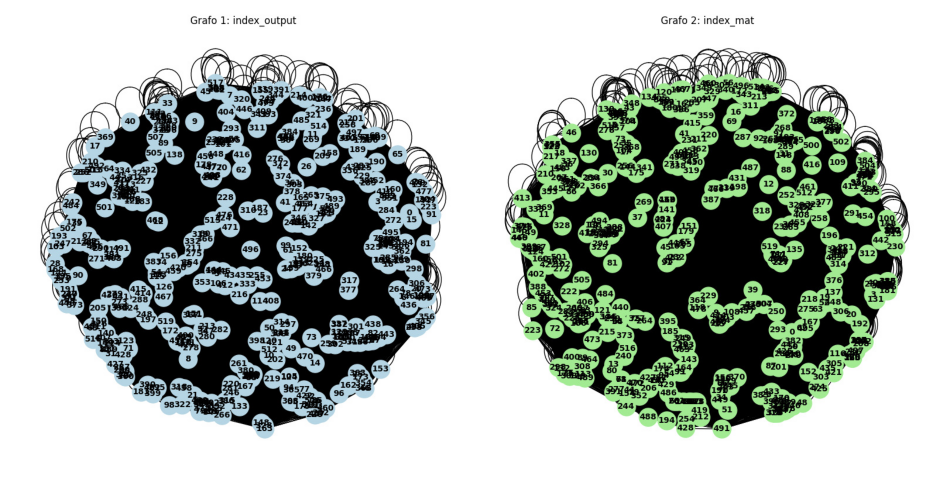

In [ ]:
edges_output = index_output.T  # Transponer para obtener pares de aristas
G1 = nx.Graph()  # Grafo 1 (no dirigido)
G1.add_edges_from(edges_output)

# Convertir index_mat (PyTorch tensor) en lista de aristas
edges_mat = index_mat.T.detach().numpy()  # Transponer y convertir a numpy
G2 = nx.Graph()  # Grafo 2 (no dirigido)
G2.add_edges_from(edges_mat)

# Dibujar los dos grafos en subplots
plt.figure(figsize=(16, 8))

# Subplot para el primer grafo
plt.subplot(1, 2, 1)
pos1 = nx.spring_layout(G1)  # Layout para distribuir los nodos
nx.draw(G1, pos1, with_labels=True, node_size=500, node_color="lightblue", font_size=10, font_weight="bold")
plt.title("Grafo 1: index_output")

# Subplot para el segundo grafo
plt.subplot(1, 2, 2)
pos2 = nx.spring_layout(G2)  # Otro layout para el segundo grafo
nx.draw(G2, pos2, with_labels=True, node_size=500, node_color="lightgreen", font_size=10, font_weight="bold")
plt.title("Grafo 2: index_mat")

# Mostrar los grafos
plt.tight_layout()
plt.show()
